In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ----- Upload manually through Colab UI -----
# Then check:
!ls /content

# Load input and model npz files
train = np.load("/content/TADPOLE_D1_D2.train.npz", allow_pickle=True)
model = np.load("/content/TADPOLE_D1_D2.train.rank2.model.npz", allow_pickle=True)

# Inspect keys
print("Train keys:", train.files)
print("Model keys:", model.files)


sample_data  TADPOLE_D1_D2.train.npz  TADPOLE_D1_D2.train.rank2.model.npz
Train keys: ['X', 'M', 'patients', 'months', 'feature_cols', 'patient_dx', 'patient_dx_first', 'patient_dx_last', 'patient_dx_trajectory', 'patient_dx_category', 'patient_is_converter', 'feature_means', 'feature_frobs', 'meta_json']
Model keys: ['weights', 'factors', 'projections', 'A_k', 'B', 'C', 'errors', 'meta']


In [ ]:
# From train
X = train['X']          # (N, F, T)
M = train['M']
patients = train['patients']
months = train['months']
labels = train['patient_is_converter']

n_patients, n_features, n_time = X.shape
print("Total patients:", n_patients)

# Count visits per patient
num_visits = (M.sum(axis=1) > 0).sum(axis=1)   # number of observed visits per patient
print("Num visits range:", num_visits.min(), "to", num_visits.max())

# Filter out one-visit patients
keep_idx = np.where(num_visits >= 2)[0]
filtered_patients = patients[keep_idx]
print("Kept patients:", len(filtered_patients))

# PARAFAC2 projections
projections = model['projections']
print("Projections:", len(projections))


Total patients: 604
Num visits range: 1 to 19
Kept patients: 578
Projections: 578


In [ ]:
# 1-to-1 mapping between projections and filtered patients
proj_to_patient = dict(enumerate(filtered_patients))

# Save mapping for reproducibility
np.save("/content/projection_patient_ids.npy", filtered_patients)
print("Saved mapping → projection_patient_ids.npy")

# Sanity check example
for i in range(3):
    print(f"Projection {i} → Patient ID {proj_to_patient[i]}")


Saved mapping → projection_patient_ids.npy
Projection 0 → Patient ID 4762
Projection 1 → Patient ID 4900
Projection 2 → Patient ID 1337


In [ ]:
delta_t_list, mask_list = [], []

for i, pid in enumerate(filtered_patients):
    # mask & X for this patient
    Mi = M[keep_idx[i]]        # (F, T)
    Xi = X[keep_idx[i]]        # (F, T)

    # identify observed visit indices
    visit_idx = np.where(Mi.sum(axis=0) > 0)[0]
    t_months = months[visit_idx]

    # Δt between consecutive visits (months)
    delta_t = np.zeros(len(t_months), dtype=np.float32)
    delta_t[1:] = np.diff(t_months)
    delta_t_list.append(delta_t)

    # simple mask: every latent timestep is valid (1)
    Ui = projections[i]
    mask = np.ones_like(Ui, dtype=np.float32)
    mask_list.append(mask)

# Sanity check
print("Example Δt:", delta_t_list[0])
print("Example mask shape:", mask_list[0].shape)


Example Δt: [0. 3. 3. 6. 6. 6.]
Example mask shape: (6, 2)


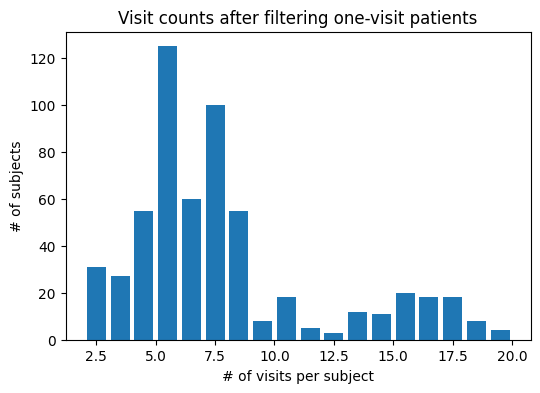

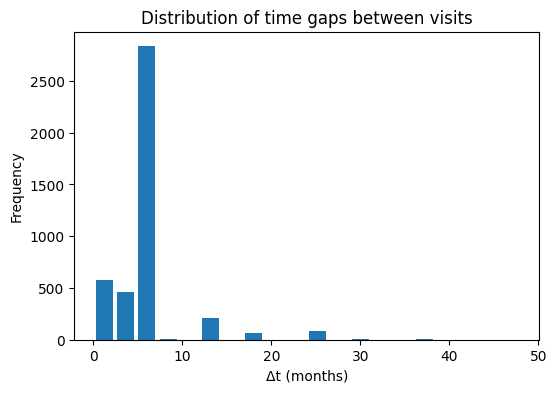

In [ ]:
lengths = [u.shape[0] for u in projections]
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=range(2, 21), rwidth=0.8)
plt.xlabel("# of visits per subject")
plt.ylabel("# of subjects")
plt.title("Visit counts after filtering one-visit patients")
plt.show()

# Distribution of delta_t across all visits
all_dt = np.concatenate(delta_t_list)
plt.figure(figsize=(6,4))
plt.hist(all_dt, bins=20, rwidth=0.8)
plt.xlabel("Δt (months)")
plt.ylabel("Frequency")
plt.title("Distribution of time gaps between visits")
plt.show()


In [ ]:
# Get labels for retained (multi-visit) patients
filtered_labels = labels[keep_idx]

# Repackage as object arrays for variable-length sequences
projections_obj = np.array(projections, dtype=object)
delta_t_obj = np.array(delta_t_list, dtype=object)
mask_obj = np.array(mask_list, dtype=object)
patients_obj = np.array(filtered_patients, dtype=object)
labels_obj = np.array(filtered_labels, dtype=object)

# Save safely using allow_pickle=True
np.savez(
    "/content/GRU_ready_latents.npz",
    projections=projections_obj,
    delta_t=delta_t_obj,
    mask=mask_obj,
    patients=patients_obj,
    labels=labels_obj,
    allow_pickle=True
)

print("✅ Saved GRU_ready_latents.npz (variable-length data preserved)")


✅ Saved GRU_ready_latents.npz (variable-length data preserved)


In [ ]:
data = np.load("/content/GRU_ready_latents.npz", allow_pickle=True)
print("Keys:", data.files)
print("Loaded", len(data["projections"]), "latent sequences.")
print("Example latent shape:", data["projections"][0].shape)
print("Example Δt:", data["delta_t"][0])


Keys: ['projections', 'delta_t', 'mask', 'patients', 'labels', 'allow_pickle']
Loaded 578 latent sequences.
Example latent shape: (6, 2)
Example Δt: [0. 3. 3. 6. 6. 6.]


GRU

In [ ]:
"""
CORRECT COMPLETE SOTA GRU-D PIPELINE FOR ALZHEIMER'S CONVERSION PREDICTION
============================================================================

PROPER EVALUATION STRATEGY:
1. Split: 70% train+val, 30% test (test set HELD OUT)
2. 5-Fold CV on train+val ONLY (for model selection/tuning)
3. Train final model on ALL train+val data
4. Evaluate ONCE on held-out test set

This ensures no data leakage and proper generalization testing.
"""

# ============================================================================
# CELL 1: IMPORTS AND SETUP
# ============================================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                            accuracy_score, f1_score, classification_report,
                            confusion_matrix)
import time
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print("="*70)


# ============================================================================
# CELL 2: LOAD DATA
# ============================================================================

print("\n📂 Loading preprocessed data...")
data = np.load("/content/GRU_ready_latents.npz", allow_pickle=True)

projections = data['projections']
delta_t_list = data['delta_t']
mask_list = data['mask']
patients = data['patients']
labels = data['labels']

labels_arr = np.array([int(x) for x in labels], dtype=np.int64)

N = len(projections)
R = projections[0].shape[1]

print(f"✓ Loaded {N} subjects")
print(f"✓ Latent dimension: {R}")
print(f"✓ Class distribution: {labels_arr.sum()} positive ({100*labels_arr.mean():.1f}%), "
      f"{(1-labels_arr).sum()} negative ({100*(1-labels_arr.mean()):.1f}%)")
print("="*70)


# ============================================================================
# CELL 3: INITIAL TRAIN+VAL / TEST SPLIT (70/30)
# ============================================================================

print("\n🔀 Creating initial train+val / test split (70/30)...")

# First split: 70% train+val, 30% test
train_val_idx, test_idx = train_test_split(
    np.arange(N),
    test_size=0.30,
    stratify=labels_arr,
    random_state=42
)

train_val_labels = labels_arr[train_val_idx]
test_labels = labels_arr[test_idx]

print(f"✓ Train+Val: {len(train_val_idx)} samples ({100*train_val_labels.mean():.1f}% positive)")
print(f"✓ Test:      {len(test_idx)} samples ({100*test_labels.mean():.1f}% positive)")
print("\n⚠️  TEST SET IS NOW LOCKED - Will only be used for final evaluation!")
print("="*70)


# ============================================================================
# CELL 4: DATASET AND DATALOADER
# ============================================================================

class LatentSeqDataset(Dataset):
    """Dataset for variable-length latent sequences"""
    def __init__(self, indices):
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        U = projections[idx].astype(np.float32)
        mask = mask_list[idx].astype(np.float32)
        dt = delta_t_list[idx].astype(np.float32)
        label = int(labels_arr[idx])
        return U, mask, dt, label, idx


def collate_fn(batch):
    """Collate variable-length sequences with padding"""
    lengths = [b[0].shape[0] for b in batch]
    maxlen = max(lengths)
    batch_size = len(batch)
    R = batch[0][0].shape[1]

    X = torch.zeros((batch_size, maxlen, R), dtype=torch.float32)
    M = torch.zeros((batch_size, maxlen, R), dtype=torch.float32)
    DT = torch.zeros((batch_size, maxlen), dtype=torch.float32)
    labels = torch.zeros(batch_size, dtype=torch.float32)
    idxs = []

    for i, (u, m, dt, label, idx) in enumerate(batch):
        L = u.shape[0]
        X[i, :L] = torch.from_numpy(u)
        M[i, :L] = torch.from_numpy(m)
        DT[i, :L] = torch.from_numpy(dt)
        labels[i] = float(label)
        idxs.append(idx)

    lengths_t = torch.tensor(lengths, dtype=torch.long)
    return X, M, DT, labels, lengths_t, idxs


print("\n✓ Dataset classes defined")
print("="*70)


# ============================================================================
# CELL 5: CLASS-BALANCED LOSS
# ============================================================================

class ClassBalancedLoss(nn.Module):
    """Class-Balanced Loss for imbalanced classification"""
    def __init__(self, samples_per_class, beta=0.9999, gamma=2.0):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

        effective_num = 1.0 - np.power(beta, samples_per_class)
        weights = (1.0 - beta) / np.array(effective_num)
        weights = weights / weights.sum() * len(weights)

        self.class_weights = torch.FloatTensor(weights)

    def forward(self, logits, targets):
        device = logits.device
        self.class_weights = self.class_weights.to(device)

        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')

        probs = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (1 - pt) ** self.gamma

        alpha_t = torch.where(targets == 1,
                             self.class_weights[1],
                             self.class_weights[0])

        loss = alpha_t * focal_weight * bce
        return loss.mean()


print("\n✓ Class-Balanced Loss defined")
print("="*70)


# ============================================================================
# CELL 6: GRU-D MODEL
# ============================================================================

class SimpleRobustGRUD(nn.Module):
    """GRU-D with temporal decay and missing value imputation"""
    def __init__(self, input_size, hidden_size=128, dropout=0.3):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.decay_x = nn.Sequential(nn.Linear(1, input_size), nn.Tanh())
        self.decay_h = nn.Sequential(nn.Linear(1, hidden_size), nn.Tanh())

        self.register_buffer('x_mean', torch.zeros(input_size))
        self.gru = nn.GRUCell(input_size, hidden_size)
        self.hidden_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, nn.GRUCell):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)

    def forward(self, X, M, DT, lengths):
        device = X.device
        B, T, R = X.shape

        h = torch.zeros(B, self.hidden_size, device=device)
        last_x = self.x_mean.unsqueeze(0).expand(B, -1).to(device)
        x_mean = self.x_mean.unsqueeze(0).expand(B, -1).to(device)

        all_h = []
        lengths_dev = lengths.to(device)

        for t in range(T):
            valid_t = (lengths_dev > t).float().unsqueeze(1)

            x_t = X[:, t, :]
            m_t = M[:, t, :]
            dt_t = DT[:, t].unsqueeze(1)

            gamma_x = torch.sigmoid(self.decay_x(dt_t))
            gamma_h = torch.sigmoid(self.decay_h(dt_t))

            x_decay = gamma_x * last_x + (1.0 - gamma_x) * x_mean
            x_t_imputed = m_t * x_t + (1.0 - m_t) * x_decay

            observed = (m_t > 0.5).float()
            update_mask = (valid_t * observed).bool()
            last_x = torch.where(update_mask, x_t, last_x)

            h_decayed = gamma_h * h
            h_new = self.gru(x_t_imputed, h_decayed)
            h_new = self.hidden_norm(h_new)

            valid_mask = valid_t.expand(-1, self.hidden_size).bool()
            h = torch.where(valid_mask, h_new, h)

            all_h.append(h.unsqueeze(1))

        H = torch.cat(all_h, dim=1)
        idx = (lengths - 1).clamp(min=0)
        last_h = H[torch.arange(B), idx, :]
        last_h = self.dropout(last_h)
        logits = self.fc(last_h).squeeze(-1)

        return logits


print("\n✓ GRU-D model defined")
print("="*70)


# ============================================================================
# CELL 7: EVALUATION FUNCTION
# ============================================================================

def evaluate_with_threshold(model, loader, device):
    """Evaluate model with optimal threshold finding"""
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X, M, DT, labels_batch, lengths, _ in loader:
            X = X.to(device)
            M = M.to(device)
            DT = DT.to(device)
            lengths = lengths.to(device)

            logits = model(X, M, DT, lengths)
            probs = torch.sigmoid(logits).cpu().numpy()

            all_labels.extend(labels_batch.numpy())
            all_probs.extend(probs)

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Find best threshold
    best_f1 = 0
    best_thresh = 0.5

    for thresh in np.arange(0.1, 0.9, 0.05):
        preds = (all_probs >= thresh).astype(int)
        f1 = f1_score(all_labels, preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    preds = (all_probs >= best_thresh).astype(int)

    return {
        'auc': roc_auc_score(all_labels, all_probs),
        'pr': average_precision_score(all_labels, all_probs),
        'acc': accuracy_score(all_labels, preds),
        'f1': f1_score(all_labels, preds, zero_division=0),
        'threshold': best_thresh,
        'labels': all_labels,
        'probs': all_probs,
        'preds': preds
    }


print("\n✓ Evaluation function defined")
print("="*70)


# ============================================================================
# CELL 8: TRAIN SINGLE MODEL
# ============================================================================

def train_model(train_idx, val_idx, config, verbose=True):
    """Train a single model with given train/val split"""

    train_ds = LatentSeqDataset(train_idx)
    val_ds = LatentSeqDataset(val_idx)

    # Weighted sampling
    train_labels = labels_arr[train_idx]
    class_counts = np.bincount(train_labels)
    class_weights = 1. / class_counts
    sample_weights = class_weights[train_labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    train_loader = DataLoader(train_ds, batch_size=config['batch_size'],
                             sampler=sampler, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=config['batch_size'],
                           shuffle=False, collate_fn=collate_fn)

    # Model
    model = SimpleRobustGRUD(
        input_size=R,
        hidden_size=config['hidden_size'],
        dropout=config['dropout']
    ).to(device)

    # Loss
    criterion = ClassBalancedLoss(samples_per_class=class_counts,
                                  beta=0.9999, gamma=2.0)

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=config['lr'],
                                  weight_decay=config['weight_decay'])

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )

    # Training loop
    best_val_metric = -1.0
    patience_ctr = 0
    best_model_state = None

    for epoch in range(1, config['n_epochs'] + 1):
        # Train
        model.train()
        losses = []

        for X, M, DT, labels_batch, lengths, _ in train_loader:
            X = X.to(device)
            M = M.to(device)
            DT = DT.to(device)
            lengths = lengths.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            logits = model(X, M, DT, lengths)
            loss = criterion(logits, labels_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            losses.append(loss.item())

        train_loss = np.mean(losses)

        # Validate
        val_metrics = evaluate_with_threshold(model, val_loader, device)
        scheduler.step(val_metrics['auc'])

        if verbose and (epoch % 5 == 0 or epoch == 1):
            print(f"  Epoch {epoch:3d} | Loss {train_loss:.4f} | "
                  f"Val AUC {val_metrics['auc']:.4f} | Val F1 {val_metrics['f1']:.4f}")

        # Early stopping
        metric = val_metrics['auc'] + val_metrics['f1']
        if metric > best_val_metric + 1e-4:
            best_val_metric = metric
            best_model_state = model.state_dict().copy()
            patience_ctr = 0
        else:
            patience_ctr += 1

        if patience_ctr >= config['patience']:
            if verbose:
                print(f"  Early stopping at epoch {epoch}")
            break

    model.load_state_dict(best_model_state)
    return model, val_metrics


print("\n✓ Training function defined")
print("="*70)


# ============================================================================
# CELL 9: 5-FOLD CV ON TRAIN+VAL (FOR MODEL SELECTION)
# ============================================================================

def run_5fold_cv_for_tuning(train_val_idx, config):
    """
    5-Fold CV on train+val data ONLY.
    Purpose: Model selection and hyperparameter tuning.
    Test set is NOT used here!
    """
    print("\n" + "="*70)
    print("5-FOLD CV FOR MODEL SELECTION (on train+val only)")
    print("="*70)
    print("⚠️  Test set is NOT involved in this step!")
    print("="*70)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_val_labels = labels_arr[train_val_idx]

    cv_results = []

    for fold, (fold_train_idx, fold_val_idx) in enumerate(
        kfold.split(train_val_idx, train_val_labels)
    ):
        print(f"\n{'─'*70}")
        print(f"CV FOLD {fold + 1}/5")
        print(f"{'─'*70}")

        # Map to original indices
        fold_train = train_val_idx[fold_train_idx]
        fold_val = train_val_idx[fold_val_idx]

        print(f"Train: {len(fold_train)} samples ({100*labels_arr[fold_train].mean():.1f}% pos)")
        print(f"Val:   {len(fold_val)} samples ({100*labels_arr[fold_val].mean():.1f}% pos)")

        # Train model
        model, val_metrics = train_model(fold_train, fold_val, config, verbose=True)

        cv_results.append(val_metrics)
        print(f"Val AUC: {val_metrics['auc']:.4f} | Val F1: {val_metrics['f1']:.4f}")

    # Summary
    print("\n" + "="*70)
    print("CV RESULTS SUMMARY")
    print("="*70)
    for metric in ['auc', 'pr', 'f1', 'acc']:
        values = [r[metric] for r in cv_results]
        print(f"{metric.upper():6s}: {np.mean(values):.4f} ± {np.std(values):.4f}")
    print("="*70)

    return cv_results


print("\n✓ CV function defined")
print("="*70)


# ============================================================================
# CELL 10: TRAIN FINAL MODEL AND EVALUATE ON TEST
# ============================================================================

def train_final_model_and_evaluate():
    """
    Complete pipeline:
    1. 5-fold CV on train+val (model selection)
    2. Train final model on ALL train+val
    3. Evaluate ONCE on held-out test set
    """

    config = {
        'hidden_size': 128,
        'dropout': 0.3,
        'lr': 1e-3,
        'weight_decay': 1e-4,
        'n_epochs': 100,
        'patience': 12,
        'batch_size': 64
    }

    print("\n" + "🚀"*35)
    print("COMPLETE PIPELINE WITH PROPER TEST SET EVALUATION")
    print("🚀"*35)

    start_time = time.time()

    # STEP 1: 5-Fold CV on train+val (model selection)
    print("\n" + "="*70)
    print("STEP 1: Model Selection via 5-Fold CV")
    print("="*70)
    cv_results = run_5fold_cv_for_tuning(train_val_idx, config)

    # STEP 2: Train final model on ALL train+val
    print("\n" + "="*70)
    print("STEP 2: Training Final Model on ALL Train+Val Data")
    print("="*70)
    print(f"Using {len(train_val_idx)} samples for final training")
    print(f"Class distribution: {100*train_val_labels.mean():.1f}% positive")

    # Split train+val into 85/15 for final training
    final_train_idx, final_val_idx = train_test_split(
        train_val_idx,
        test_size=0.15,
        stratify=train_val_labels,
        random_state=42
    )

    print(f"\nFinal train: {len(final_train_idx)} samples")
    print(f"Final val:   {len(final_val_idx)} samples")
    print("\nTraining final model...")

    final_model, final_val_metrics = train_model(
        final_train_idx, final_val_idx, config, verbose=True
    )

    print(f"\nFinal model validation metrics:")
    print(f"  AUC: {final_val_metrics['auc']:.4f}")
    print(f"  F1:  {final_val_metrics['f1']:.4f}")

    # STEP 3: Evaluate on held-out test set
    print("\n" + "="*70)
    print("STEP 3: FINAL EVALUATION ON HELD-OUT TEST SET")
    print("="*70)
    print("⚠️  This is the FIRST TIME the model sees the test data!")
    print("="*70)

    test_ds = LatentSeqDataset(test_idx)
    test_loader = DataLoader(test_ds, batch_size=config['batch_size'],
                            shuffle=False, collate_fn=collate_fn)

    test_metrics = evaluate_with_threshold(final_model, test_loader, device)

    elapsed = time.time() - start_time

    # FINAL RESULTS
    print("\n" + "="*70)
    print("✅ FINAL TEST SET RESULTS")
    print("="*70)
    print(f"AUC:      {test_metrics['auc']:.4f}")
    print(f"AUPRC:    {test_metrics['pr']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"Accuracy: {test_metrics['acc']:.4f}")
    print(f"Optimal Threshold: {test_metrics['threshold']:.3f}")
    print("="*70)

    print("\nDetailed Classification Report:")
    print(classification_report(
        test_metrics['labels'],
        test_metrics['preds'],
        target_names=['Non-Converter', 'Converter'],
        digits=4
    ))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_metrics['labels'], test_metrics['preds'])
    print(cm)
    print(f"\nTrue Negatives:  {cm[0,0]}")
    print(f"False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}")
    print(f"True Positives:  {cm[1,1]}")

    # Clinical metrics
    sensitivity = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0
    specificity = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
    ppv = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    npv = cm[0,0] / (cm[0,0] + cm[1,0]) if (cm[0,0] + cm[1,0]) > 0 else 0

    print(f"\n{'='*70}")
    print("CLINICAL INTERPRETATION")
    print("="*70)
    print(f"Sensitivity (Recall):    {sensitivity:.1%} - detects {sensitivity:.1%} of converters")
    print(f"Specificity:             {specificity:.1%} - correctly IDs {specificity:.1%} of non-converters")
    print(f"Precision (PPV):         {ppv:.1%} - {ppv:.1%} of positive predictions are correct")
    print(f"Negative Pred. Value:    {npv:.1%} - {npv:.1%} of negative predictions are correct")
    print("="*70)

    print(f"\n⏱️  Total pipeline time: {elapsed/60:.1f} minutes")

    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print("✓ 5-fold CV completed on train+val (for model selection)")
    print("✓ Final model trained on all train+val data")
    print("✓ Test set evaluated ONCE (no data leakage)")
    print(f"✓ Final Test AUC: {test_metrics['auc']:.4f}")
    print(f"✓ Final Test F1:  {test_metrics['f1']:.4f}")
    print("="*70)

    return cv_results, final_model, test_metrics


print("\n✓ Final evaluation function defined")
print("="*70)


# ============================================================================
# CELL 11: RUN COMPLETE PIPELINE
# ============================================================================

if __name__ == "__main__":
    cv_results, final_model, test_metrics = train_final_model_and_evaluate()

Device: cuda

📂 Loading preprocessed data...
✓ Loaded 578 subjects
✓ Latent dimension: 2
✓ Class distribution: 78 positive (13.5%), 500 negative (86.5%)

🔀 Creating initial train+val / test split (70/30)...
✓ Train+Val: 404 samples (13.6% positive)
✓ Test:      174 samples (13.2% positive)

⚠️  TEST SET IS NOW LOCKED - Will only be used for final evaluation!

✓ Dataset classes defined

✓ Class-Balanced Loss defined

✓ GRU-D model defined

✓ Evaluation function defined

✓ Training function defined

✓ CV function defined

✓ Final evaluation function defined

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
COMPLETE PIPELINE WITH PROPER TEST SET EVALUATION
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀

STEP 1: Model Selection via 5-Fold CV

5-FOLD CV FOR MODEL SELECTION (on train+val only)
⚠️  Test set is NOT involved in this step!

──────────────────────────────────────────────────────────────────────
CV FOLD 1/5
──────────────────────────────────────────────────────────────────────
Train: 323 samples (13.6% p